In [179]:
import gpflow as gpf
import numpy as np
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Markdown, Latex
tf.logging.set_verbosity(tf.logging.FATAL)
plt.style.use("slides")

## Generate fake noisey 1-D point robot on a line

one dimensional state, $x_t$

In [180]:
class NoisyLinearModel:
    
    def __init__(self, a, b, variance):
        self.a = a
        self.b = b
        self.variance = variance
        self.stdev = np.sqrt(self.variance)
        
    def fwd(self, x):
        return self.a * x + self.b

    def fwd_w_noise(self, x):
        return self.fwd(x) + np.random.normal(0, self.stdev)
    
    def display(self):
        display(Latex("$x_{t+1} = " + str(self.a) + "x_t + " + str(self.b) + " + \mathcal{N}(0," + str(self.variance) + ")$"))

In [353]:
true_model = NoisyLinearModel(a=-2.0, b=5.0, variance=0.5)
true_model.display()

<IPython.core.display.Latex object>

In [354]:
n = 100
np.random.seed(0)
train_x = np.random.uniform(-5, 5, size=(n, 1))
train_y = np.empty_like(train_x)
for i in range(n):
    train_y[i] = true_model.fwd_w_noise(train_x[i])
    
test_x = np.expand_dims(np.linspace(-10, 10, 20), axis=1)
test_y = np.empty_like(test_x)
for i in range(len(test_x)):
    test_y[i] = true_model.fwd_w_noise(test_x[i])

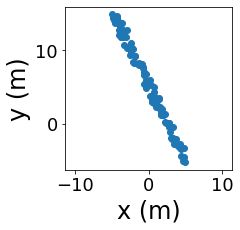

In [355]:
plt.figure(figsize=(3,3))
plt.scatter(train_x, train_y)
plt.axis("equal")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

In [356]:
gpf.reset_default_graph_and_session()
k = gpf.kernels.RBF(1)
mean = None
# mean = gpf.mean_functions.Linear()
m = gpf.models.GPR(train_x, train_y, kern=k, mean_function=mean)
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [357]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m);
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,23.120554098788574
GPR/kern/variance,Parameter,None,+ve,True,(),True,762.0420797438381
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.500557024405747


In [358]:
true_model.display()

<IPython.core.display.Latex object>

In [359]:
m.compute_log_likelihood()

-118.53646847680841

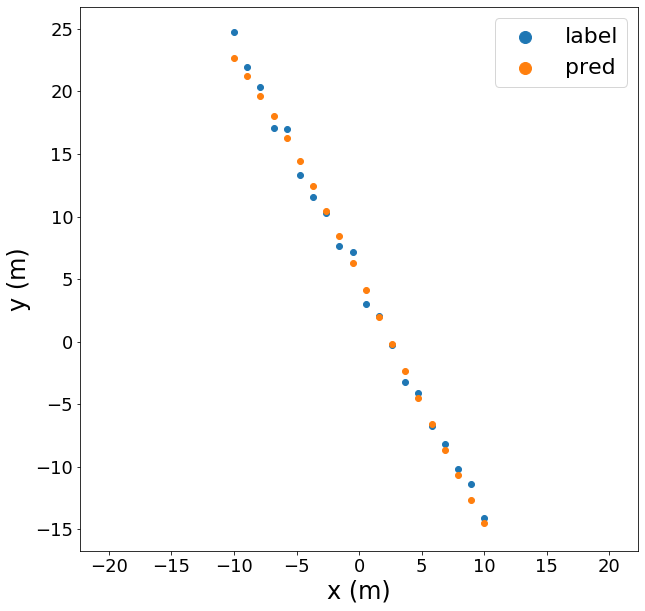

In [360]:
pred_y_mean = m.predict_f(test_x)[0]
plt.figure(figsize=(10,10))
plt.scatter(test_x, test_y, label='label')
plt.scatter(test_x, pred_y_mean, label='pred')
plt.axis("equal")
plt.legend()
plt.xlabel("x (m)")
plt.ylabel("y (m)");